# 初始化环境 

In [1]:
import os
# 对于高版本python（3.11）需要高版本spark与之配套
# os.environ["SPARK_HOME"] = R"F:\spark_local\spark-3.4.2-bin-hadoop3"
# os.environ["HADOOP_HOME"] = R"F:\spark_local\hadoop-3.3.5"

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = (
         SparkSession
         .builder
         .appName("SimpleApp")
         .getOrCreate()
        )

# 窗口函数

In [6]:
# 初始化数据
logFile = "./data/order_tab.csv"  
from pyspark.sql.types import FloatType,StringType,DateType,IntegerType,StructType,StructField
schema = StructType(
    [StructField("order_id",IntegerType(),True),
    StructField("user_no",StringType(),True),
    StructField("amount",IntegerType(),True),
    StructField("create_date",DateType(),True)
    ]
)

logData = spark.read.csv(logFile,schema=schema,header=True)
logData.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- user_no: string (nullable = true)
 |-- amount: integer (nullable = true)
 |-- create_date: date (nullable = true)



In [7]:
logData.createOrReplaceTempView("order_tab")
spark.sql("select * from order_tab").show()

+--------+-------+------+-----------+
|order_id|user_no|amount|create_date|
+--------+-------+------+-----------+
|       1|    001|   100| 2019-01-01|
|       2|    001|   300| 2019-01-02|
|       3|    001|   500| 2019-01-02|
|       4|    001|   800| 2019-01-03|
|       5|    001|   900| 2019-01-04|
|       6|    002|   500| 2019-01-03|
|       7|    002|   600| 2019-01-04|
|       8|    002|   300| 2019-01-10|
|       9|    002|   800| 2019-01-16|
|      10|    002|   800| 2019-01-22|
+--------+-------+------+-----------+



## 什么是窗口函数

窗口函数也叫分析函数、排序函数。
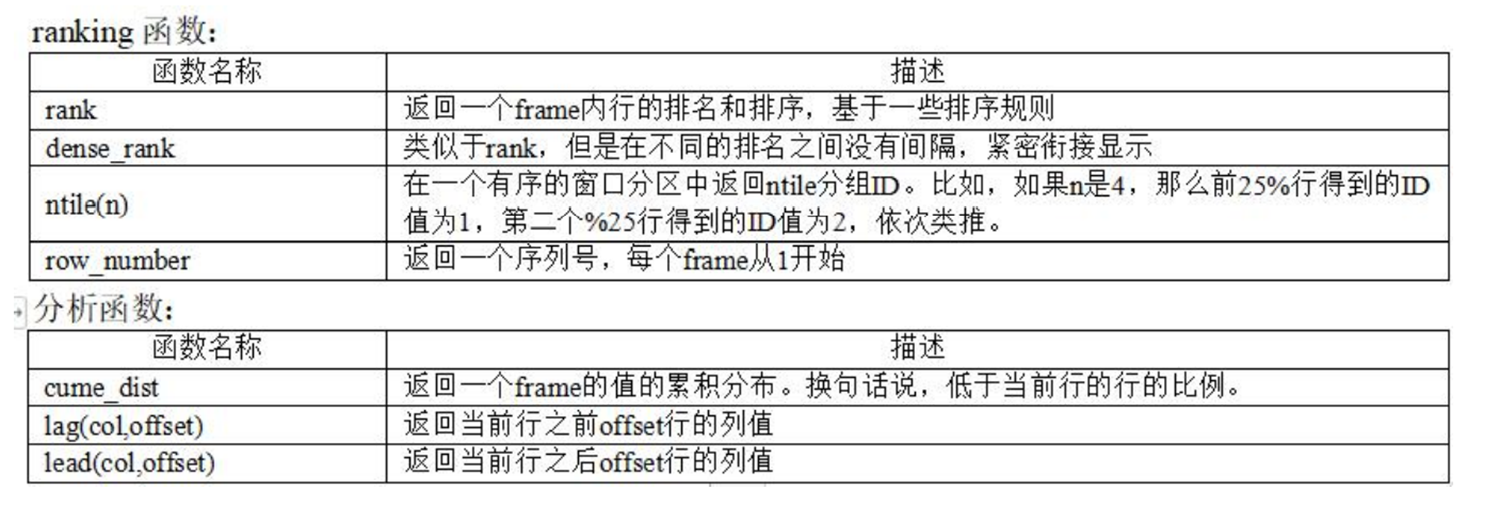

它可以理解为记录集合，开窗函数也就是在满足某种条件的记录集合上执行的特殊函数。对于每条记录都要在此窗口内执行函数，有的函数随着记录不同，窗口大小都是固定的，这种属于静态窗口；有的函数则相反，不同的记录对应着不同的窗口，这种动态变化的窗口叫滑动窗口。开窗函数的本质还是聚合运算，只不过它更具灵活性，它对数据的每一行，都使用与该行相关的行进行计算并返回计算结果。

### 开窗函数和普通聚合函数的区别
  聚合函数是将多条记录聚合为一条而开窗函数是每条记录都会执行，有几条记录执行完还是几条。  
  聚合函数也可以用于开窗函数中。        
  我们知道聚合函数对一组值执行计算并返回一个值，但有时候一组数据只返回一个结果值并不能满足需求。 

In [8]:
#查询每个用户的订单总金额
spark.sql("select user_no,sum(amount) from order_tab group by user_no").show()
#查询每个用户按时间顺序的累计订单金额
spark.sql("select *,sum(amount) over(partition by user_no order by create_date) cusum from order_tab").show()

spark.sql("select *,sum(amount) over(partition by user_no) cusum from order_tab").show()

+-------+-----------+
|user_no|sum(amount)|
+-------+-----------+
|    001|       2600|
|    002|       3000|
+-------+-----------+

+--------+-------+------+-----------+-----+
|order_id|user_no|amount|create_date|cusum|
+--------+-------+------+-----------+-----+
|       1|    001|   100| 2019-01-01|  100|
|       2|    001|   300| 2019-01-02|  900|
|       3|    001|   500| 2019-01-02|  900|
|       4|    001|   800| 2019-01-03| 1700|
|       5|    001|   900| 2019-01-04| 2600|
|       6|    002|   500| 2019-01-03|  500|
|       7|    002|   600| 2019-01-04| 1100|
|       8|    002|   300| 2019-01-10| 1400|
|       9|    002|   800| 2019-01-16| 2200|
|      10|    002|   800| 2019-01-22| 3000|
+--------+-------+------+-----------+-----+

+--------+-------+------+-----------+-----+
|order_id|user_no|amount|create_date|cusum|
+--------+-------+------+-----------+-----+
|       1|    001|   100| 2019-01-01| 2600|
|       2|    001|   300| 2019-01-02| 2600|
|       3|    001|   500| 2019

### 开窗函数语法结构
`开窗函数名([<字段名>]) over([partition by <分组字段>] [order by <排序字段> [desc]] [<窗口分区>])`

开窗函数的一个概念是当前行，当前行属于某个窗口，窗口由
over关键字用来指定函数执行的窗口范围，如果后面括号中什么都不写，则意味着窗口包含满足where条件的所有行，开窗函数基于所有行进行计算；如果不为空，则有三个参数来设置窗口：

- partition by子句：按照指定字段进行分区，两个分区由边界分隔，开窗函数在不同的分区内分别执行，在跨越分区边界时重新初始化。    
- order by子句：按照指定字段进行排序，开窗函数将按照排序后的记录顺序进行编号。可以和partition by子句配合使用，也可以单独使用。   
- frame子句：当前分区的一个子集，用来定义子集的规则，通常用来作为滑动窗口使用。
    - 如果order by 部分已定义，但frame部分缺省，则表示窗口为分区第一行到当前行。

示例：查询每个用户按下单时间顺序，前一行和后一行记录的平均订单金额

In [9]:
spark.sql("""
select 
      *
     ,avg(amount) over(partition by user_no order by create_date rows between 1 preceding and 1 following) avg_amount
from order_tab
""").show()

+--------+-------+------+-----------+-----------------+
|order_id|user_no|amount|create_date|       avg_amount|
+--------+-------+------+-----------+-----------------+
|       1|    001|   100| 2019-01-01|            200.0|
|       2|    001|   300| 2019-01-02|            300.0|
|       3|    001|   500| 2019-01-02|533.3333333333334|
|       4|    001|   800| 2019-01-03|733.3333333333334|
|       5|    001|   900| 2019-01-04|            850.0|
|       6|    002|   500| 2019-01-03|            550.0|
|       7|    002|   600| 2019-01-04|466.6666666666667|
|       8|    002|   300| 2019-01-10|566.6666666666666|
|       9|    002|   800| 2019-01-16|633.3333333333334|
|      10|    002|   800| 2019-01-22|            800.0|
+--------+-------+------+-----------+-----------------+



对于滑动窗口的范围指定，有两种方式：基于行和基于值。
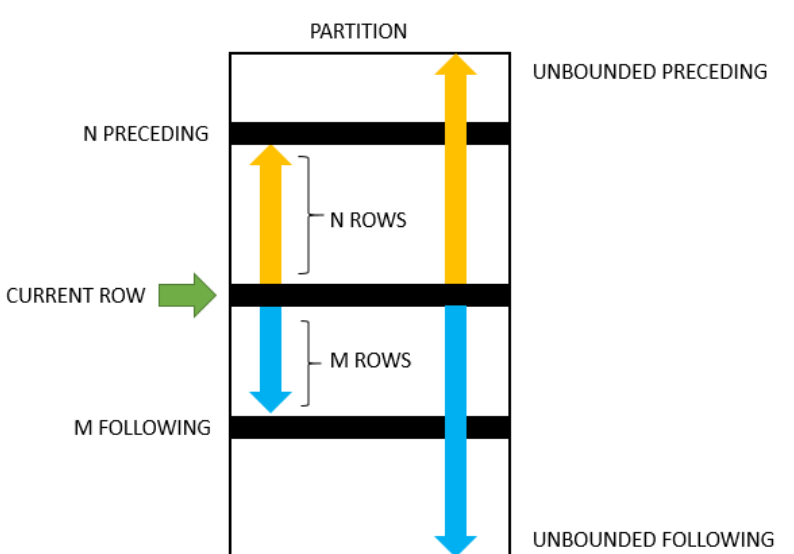
**基于行：**    

通常使用`rows between frame_start and frame_end`语法来表示行范围，`frame_start`和`frame_end`可以支持如下关键字，来确定不同的动态行记录：    
- current row 边界是当前行，一般和其他范围关键字一起使用
- unbounded preceding 边界是分区中的第一行
- unbounded following 边界是分区中的最后一行
- expr preceding 边界是当前行减去expr的值
- expr following 边界是当前行加上expr的值    
比如，下面都是合法的行范围：

- rows between 1 preceding and 1 following 窗口范围是分区中的当前行、前一行、后一行一共三行记录。
- rows between 1 preceding and current row 窗口范围是分区中的前一行、当前行一共两行记录。
- rows between current row and 1 following 窗口范围是分区中的当前行、后一行一共两行记录。
- rows unbounded preceding 窗口范围是分区中的第一行到当前行。
- rows between unbounded preceding and current row 窗口范围是分区中的第一行到当前行。
- rows between current row and unbounded following 窗口范围是分区中的当前行到最后一行。
- rows between unbounded preceding and unbounded following 窗口范围是当前分区中的第一行到最后一行。

**基于值：**        
和基于行类似，通常使用`range between frame_start and frame_end`语法来表示值范围。比如，下面都是合法的值范围：

- range between 1 preceding and 1 following 窗口范围是分区中的当前行对应值-1和当前行对应值+1范围内的记录。
- range between 1 preceding and current row 窗口范围是分区中的当前行对应值-1和当前行范围内的记录。
- range between current row and 1 following 窗口范围是分区中的当前行对应值和当前行对应值+1范围内的记录。
- range unbounded preceding 窗口范围是分区中的第一行对应值和当前行对应值范围内的记录。
- range between unbounded preceding and current row 窗口范围是分区中的第一行对应值和当前行对应值范围内的记录。
- range between current row and unbounded following 窗口范围是分区中的当前行对应值和最后一行对应值范围内的记录。
- range between unbounded preceding and unbounded following 窗口范围是当前分区中的第一行对应值和最后一行对应值范围内的记录。

## row_number
显示分区中的当前序号     
示例：查询每个用户订单金额最高的前三个订单

In [10]:
spark.sql("""
select 
     *
from 
(select 
     *
    ,row_number() over(partition by user_no order by amount desc) rb

from order_tab) t
where rb<4
""").show()

+--------+-------+------+-----------+---+
|order_id|user_no|amount|create_date| rb|
+--------+-------+------+-----------+---+
|       5|    001|   900| 2019-01-04|  1|
|       4|    001|   800| 2019-01-03|  2|
|       3|    001|   500| 2019-01-02|  3|
|       9|    002|   800| 2019-01-16|  1|
|      10|    002|   800| 2019-01-22|  2|
|       7|    002|   600| 2019-01-04|  3|
+--------+-------+------+-----------+---+



## rank与dense_rank

以上结果中用户‘002’的前两个订单的金额都是800，随机排为第一和第二，但实际两笔订单金额应该并列第一。    
这种情况row_number函数就不能满足需求，需要rank和dense_rank函数。这两个函数和row_number函数类似，只是在出现重复值时处理逻辑不同。        
示例：使用三个不同的序号函数，查询不同用户的订单中，按照订单金额进行排序，显示出相应的排名

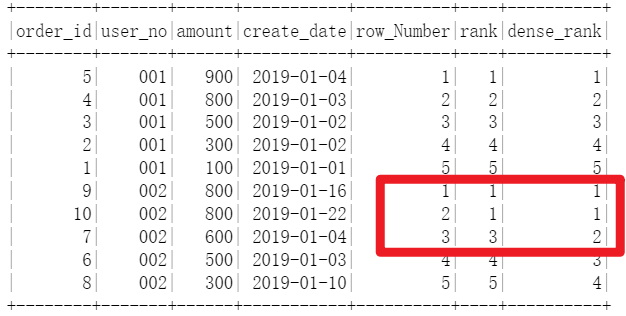

## 前后函数 lag(n)/lead(n)
分区中位于当前行前n行（lag）/后n行(lead)的记录值    
示例：查询上一个订单距离当前订单的间隔天数

In [11]:
spark.sql("select *,lag(create_date,1) over(partition by user_no order by create_date) ldate from order_tab").show()

+--------+-------+------+-----------+----------+
|order_id|user_no|amount|create_date|     ldate|
+--------+-------+------+-----------+----------+
|       1|    001|   100| 2019-01-01|      null|
|       2|    001|   300| 2019-01-02|2019-01-01|
|       3|    001|   500| 2019-01-02|2019-01-02|
|       4|    001|   800| 2019-01-03|2019-01-02|
|       5|    001|   900| 2019-01-04|2019-01-03|
|       6|    002|   500| 2019-01-03|      null|
|       7|    002|   600| 2019-01-04|2019-01-03|
|       8|    002|   300| 2019-01-10|2019-01-04|
|       9|    002|   800| 2019-01-16|2019-01-10|
|      10|    002|   800| 2019-01-22|2019-01-16|
+--------+-------+------+-----------+----------+



In [12]:
spark.sql("""
select *
      ,datediff(create_date,ldate) diff
from  (select *
                   ,lag(create_date,1) over(partition by user_no order by create_date) ldate 
            from order_tab) t
""").show()

+--------+-------+------+-----------+----------+----+
|order_id|user_no|amount|create_date|     ldate|diff|
+--------+-------+------+-----------+----------+----+
|       1|    001|   100| 2019-01-01|      null|null|
|       2|    001|   300| 2019-01-02|2019-01-01|   1|
|       3|    001|   500| 2019-01-02|2019-01-02|   0|
|       4|    001|   800| 2019-01-03|2019-01-02|   1|
|       5|    001|   900| 2019-01-04|2019-01-03|   1|
|       6|    002|   500| 2019-01-03|      null|null|
|       7|    002|   600| 2019-01-04|2019-01-03|   1|
|       8|    002|   300| 2019-01-10|2019-01-04|   6|
|       9|    002|   800| 2019-01-16|2019-01-10|   6|
|      10|    002|   800| 2019-01-22|2019-01-16|   6|
+--------+-------+------+-----------+----------+----+



In [13]:
spark.stop()